
# HFT Strategy Prototypes

Goal: take the alpha sketches from `hft_prediction.ipynb`, wire them into `hftbacktest` strategies, and produce runnable maker/taker templates that can be re-tuned quickly.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.linear_model import LinearRegression, LogisticRegression

import modeling_utils as mu
import strategy_utils as su
from strategies import AssetBuildConfig
import data_utils

plt.style.use("bmh")
sns.set_context("talk")

import importlib
importlib.reload(su)
import strategy_utils as su


## Load features + build alphas
We reuse the same OKX feature parquet source used in `hft_eda.ipynb` and `hft_prediction.ipynb`. To keep runtime reasonable, work on the first day and train simple linear/logistic alphas on lagged returns.


In [2]:
root = Path("./target/okx_btcusdt_features_0.1_10_5_+p")
books = mu.load_okx_features(root, max_files=1)
returns = mu.compute_log_returns(books["vwap"], horizons=[1, 10])
rt10 = returns["rt10"]
rt10.describe()


count    8.639960e+05
mean     4.530320e-07
std      5.755536e-05
min     -2.138131e-02
25%     -3.604750e-06
50%      0.000000e+00
75%      4.270564e-06
max      2.150523e-02
Name: rt10, dtype: float64

In [6]:
books.shape

(863996, 44)

In [5]:
books.head()

,iso_time,vwap,buy_volume,sell_volume,ask_size_1,ask_size_2,ask_size_3,ask_size_4,ask_size_5,ask_size_6,...,bid_price_1,bid_price_2,bid_price_3,bid_price_4,bid_price_5,bid_price_6,bid_price_7,bid_price_8,bid_price_9,bid_price_10
timestamp,,,,,,,,,,,,,,,,,,,,,
1759276800500,2025-10-01T00:00:00.500Z,114046.528629,0.000000,0.000086,1.220644,0.000279,0.001537,0.034207,0.000042,0.000100,...,114047.1,114047.0,114046.2,114046.0,114045.4,114045.2,114045.0,114044.9,114044.4,114044.2
1759276800600,2025-10-01T00:00:00.600Z,114047.154241,0.001078,0.000000,1.219741,0.000279,0.001537,0.034207,0.000042,0.000100,...,114047.1,114047.0,114046.2,114046.0,114045.4,114045.2,114045.1,114045.0,114044.9,114044.4
1759276800700,2025-10-01T00:00:00.700Z,114047.154241,0.000000,0.000000,1.201651,0.000279,0.001537,0.034207,0.000042,0.000100,...,114047.1,114047.0,114046.2,114046.0,114045.4,114045.2,114045.1,114045.0,114044.9,114044.4
1759276800800,2025-10-01T00:00:00.800Z,114047.154241,0.000000,0.000000,1.201651,0.000279,0.001537,0.034207,0.000042,0.000100,...,114047.1,114047.0,114046.2,114046.0,114045.4,114045.2,114045.1,114045.0,114044.9,114044.4
1759276800900,2025-10-01T00:00:00.900Z,114048.829910,1.716061,0.000000,0.000534,0.000060,0.001807,0.002000,0.105577,0.000085,...,114054.8,114053.2,114052.7,114052.6,114052.5,114052.0,114051.9,114051.7,114051.4,114051.3


In [7]:
books.tail()

,iso_time,vwap,buy_volume,sell_volume,ask_size_1,ask_size_2,ask_size_3,ask_size_4,ask_size_5,ask_size_6,...,bid_price_1,bid_price_2,bid_price_3,bid_price_4,bid_price_5,bid_price_6,bid_price_7,bid_price_8,bid_price_9,bid_price_10
timestamp,,,,,,,,,,,,,,,,,,,,,
1759363199600,2025-10-01T23:59:59.600Z,118607.630922,0.0,0.0,0.396941,0.000011,0.010189,0.03362,0.11,0.036676,...,118607.6,118607.0,118606.0,118605.6,118605.1,118605.0,118604.5,118604.0,118603.7,118603.0
1759363199700,2025-10-01T23:59:59.700Z,118607.630922,0.0,0.0,0.396941,0.000011,0.010189,0.03362,0.11,0.036676,...,118607.6,118607.0,118606.0,118605.6,118605.1,118605.0,118604.5,118604.0,118603.7,118603.0
1759363199800,2025-10-01T23:59:59.800Z,118607.630922,0.0,0.0,0.286941,0.000011,0.010189,0.03362,0.11,0.036676,...,118607.6,118607.0,118606.0,118605.7,118605.6,118605.0,118604.5,118604.0,118603.7,118603.0
1759363199900,2025-10-01T23:59:59.900Z,118607.630922,0.0,0.0,0.295373,0.000011,0.010189,0.03362,0.11,0.036676,...,118607.6,118607.0,118606.0,118605.7,118605.6,118605.0,118604.5,118604.0,118603.7,118603.0
1759363200000,2025-10-02T00:00:00.000Z,118607.630922,0.0,0.0,0.473635,0.000011,0.010189,0.03362,0.11,0.036676,...,118607.6,118605.7,118605.6,118605.0,118604.5,118604.0,118603.7,118603.0,118601.7,118601.0


In [4]:

lags = list(range(1, 21))
lin_model, lin_preds, lin_metrics = mu.train_linear_alpha(rt10, lags=lags, horizon=10)
logit_model, prob_up, logit_metrics = mu.train_logit_alpha(rt10, lags=lags, horizon=10)

lin_metrics, logit_metrics


({'mse': 3.3003043780258346e-09}, {'val_auc': np.float64(0.5173163301813616)})

In [5]:

signals = pd.concat([
    lin_preds.rename("pred_rt10"),
    prob_up.rename("prob_up")
], axis=1)
signals["cls_signal"] = signals["prob_up"] * 2 - 1
signals["timestamp_ns"] = mu.timestamp_ms_to_ns(signals.index.to_series())
signals = signals.dropna().reset_index(drop=True)

signals.head()


,pred_rt10,prob_up,cls_signal,timestamp_ns
0,4.147600e-07,0.364554,-0.270892,1759276800500000000
1,4.147600e-07,0.364554,-0.270892,1759276800600000000
2,4.147600e-07,0.364554,-0.270892,1759276800700000000
3,4.147600e-07,0.364554,-0.270892,1759276800800000000
4,4.147600e-07,0.364554,-0.270892,1759276800900000000


In [6]:
signals.shape

(863986, 4)

In [6]:
# Build a lightweight feed from the same OKX feature snapshots used for alphas
books_for_feed = books
# timestamps are already regular; convert ms index to ns for hftbacktest
ts_ns = pd.to_numeric(books_for_feed.index, errors="coerce").astype("int64") * 1_000_000

# Two events per snapshot: best bid and best ask
n = len(books_for_feed) * 2
events = np.zeros(n, dtype=data_utils.HFT_EVENT_DTYPE)
base_flags = (data_utils.EXCH_EVENT | data_utils.LOCAL_EVENT | data_utils.DEPTH_EVENT).astype(np.uint64)
events["ev"] = base_flags

# bids on even indices, asks on odd
events["exch_ts"][::2] = ts_ns
events["local_ts"][::2] = ts_ns
events["px"][::2] = books_for_feed["bid_price_1"].to_numpy(np.float64)
events["qty"][::2] = books_for_feed["bid_size_1"].to_numpy(np.float64)
events["ev"][::2] |= data_utils.BUY_EVENT

events["exch_ts"][1::2] = ts_ns
events["local_ts"][1::2] = ts_ns
events["px"][1::2] = books_for_feed["ask_price_1"].to_numpy(np.float64)
events["qty"][1::2] = books_for_feed["ask_size_1"].to_numpy(np.float64)
events["ev"][1::2] |= data_utils.SELL_EVENT

asset_cfg = AssetBuildConfig(feed=[events], tick_size=0.1, lot_size=0.001, maker_fee=0.0002, taker_fee=0.0007)
feed_start_ns = int(events["exch_ts"][0])
events.shape, feed_start_ns


((1727992,), 1759276800500000000)

In [7]:
# Build a lightweight feed from the same OKX feature snapshots used for alphas
books_for_feed = books.iloc[: len(signals)]
ts_ns = pd.to_numeric(books_for_feed.index, errors="coerce").astype("int64") * 1_000_000

# Two events per snapshot: best bid and best ask
n = len(books_for_feed) * 2
events = np.zeros(n, dtype=data_utils.HFT_EVENT_DTYPE)
base_flags = (data_utils.EXCH_EVENT | data_utils.LOCAL_EVENT | data_utils.DEPTH_EVENT).astype(np.uint64)
events["ev"] = base_flags

# bids on even indices, asks on odd
events["exch_ts"][::2] = ts_ns
events["local_ts"][::2] = ts_ns
events["px"][::2] = books_for_feed["bid_price_1"].to_numpy(np.float64)
events["qty"][::2] = books_for_feed["bid_size_1"].to_numpy(np.float64)
events["ev"][::2] |= data_utils.BUY_EVENT

events["exch_ts"][1::2] = ts_ns
events["local_ts"][1::2] = ts_ns
events["px"][1::2] = books_for_feed["ask_price_1"].to_numpy(np.float64)
events["qty"][1::2] = books_for_feed["ask_size_1"].to_numpy(np.float64)
events["ev"][1::2] |= data_utils.SELL_EVENT

asset_cfg = AssetBuildConfig(feed=[events], tick_size=0.1, lot_size=0.001, maker_fee=0.0002, taker_fee=0.0007)
feed_start_ns = int(events["exch_ts"][0])
events.shape, feed_start_ns


((1727972,), 1759276800500000000)

In [8]:

# Align alpha timestamps to the feed clock and build arrays for numba loops
aligned_signals = su.align_signal_to_feed(signals, feed_start_ns)

sig_ts_reg, sig_vals_reg = su.build_signal_arrays(aligned_signals, "pred_rt10")
sig_ts_cls, sig_vals_cls = su.build_signal_arrays(aligned_signals.assign(cls_signal=aligned_signals["cls_signal"]), "cls_signal")

sig_ts_reg[:3], sig_vals_reg[:3]


(array([1759276800500000000, 1759276800600000000, 1759276800700000000]),
 array([4.14760012e-07, 4.14760012e-07, 4.14760012e-07]))


## Alpha-driven maker strategy
A maker that skews quotes in the direction of the regression alpha. Positive signal tightens the bid/widens the ask; negative does the opposite. Inventory caps keep exposure bounded.


In [10]:

maker_cfg = su.AlphaMakerConfig(
    step_ns=50_000_000,
    base_quote_offset_ticks=0.5,
    min_spread_ticks=1.0,
    skew_scale_ticks=2.5,
    max_skew_ticks=3.0,
    quote_ttl_ns=250_000_000,
    order_size_lots=1.0,
    max_inventory_lots=3.0,
    record_every_n_steps=2,
)

# Recorder needs enough capacity for the ~len(events)/record_every_n_steps entries
maker_record_cap = len(events)
maker_result = su.run_alpha_maker_backtest(
    asset_cfg, sig_ts_reg, sig_vals_reg, maker_cfg, record_capacity=maker_record_cap
)
maker_result.summary


{'total_pnl': -218.11224999997944,
 'max_drawdown': 218.11224999997944,
 'num_trades': 18603.0,
 'turnover': 2162662.077899986,
 'final_inventory': -0.003}

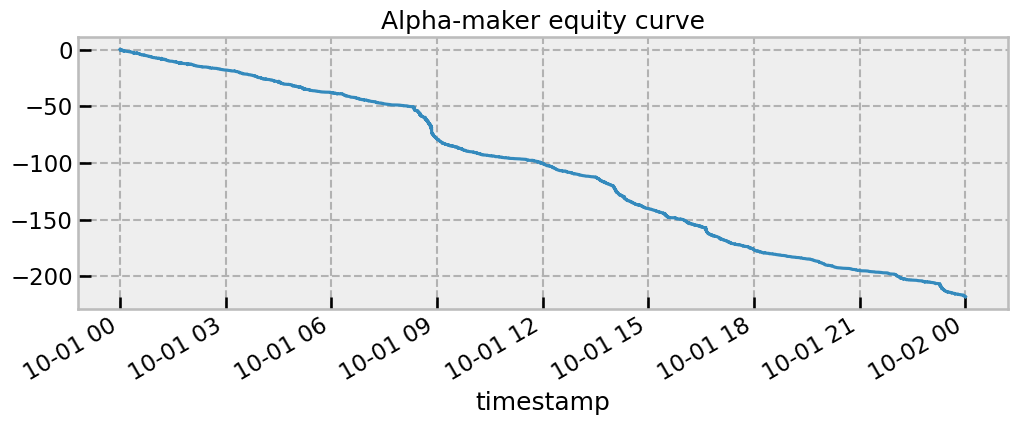

In [11]:

maker_result.frame.set_index("timestamp")["equity"].plot(figsize=(12,4), title="Alpha-maker equity curve")
plt.show()



## Alpha-driven taker strategy
Use the classification alpha (sign probability) to trigger market orders when conviction crosses thresholds, with a cooldown to avoid churn.


In [9]:

taker_cfg = su.AlphaTakerConfig(
    step_ns=20_000_000,
    buy_threshold=0.0010,
    sell_threshold=-0.0010,
    cooldown_ns=200_000_000,
    order_size_lots=1.5,
    max_inventory_lots=4.0,
    slippage_ticks=1.0,
    record_every_n_steps=2,
)

# Recorder capacity must cover the time span of the feed, not just number of events
feed_duration_ns = int(events["exch_ts"].max() - events["exch_ts"].min())
taker_steps = feed_duration_ns // taker_cfg.step_ns + 2
# one record per record_every_n_steps, plus a small buffer
bucketed_records = taker_steps // taker_cfg.record_every_n_steps + 10
taker_record_cap = int(max(len(events), bucketed_records))

taker_result = su.run_alpha_taker_backtest(
    asset_cfg, sig_ts_cls, sig_vals_cls, taker_cfg, record_capacity=taker_record_cap
)
taker_result.summary


{'total_pnl': -13.681575000000038,
 'max_drawdown': 14.100599999999986,
 'num_trades': 2.0,
 'turnover': 342.1413,
 'final_inventory': -0.003}

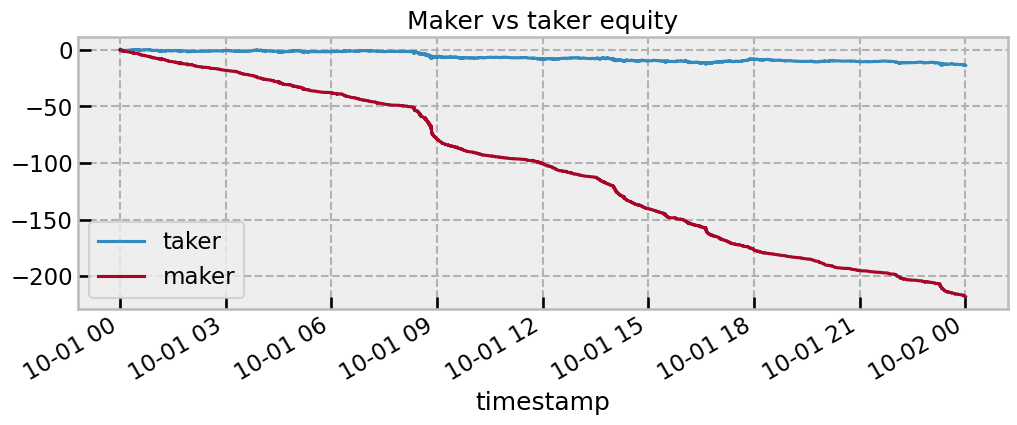

In [11]:

ax = taker_result.frame.set_index("timestamp")["equity"].plot(figsize=(12,4), label="taker")
maker_result.frame.set_index("timestamp")["equity"].plot(ax=ax, label="maker")
plt.title("Maker vs taker equity")
plt.legend()
plt.show()



### Notes and next steps
- Config objects (`AlphaMakerConfig`, `AlphaTakerConfig`) expose the knobs you will likely retune first: signal scale, thresholds, inventory caps, TTL, cooldown.
- The signal alignment helper shifts alpha timestamps to the feed start; swap in your own real-time alphas or longer history by replacing `signals`.
- For live research, consider rebuilding the signal on the same day as the feed and enriching the feature set (depth imbalance, microprice tilt, trade flow) before re-fitting the alpha.
- The backtests record equity/position/turnover; extend `strategy_utils.records_to_frame` if you want more diagnostics (fill ratio, queue position, etc.).


# Test

In [20]:
npz_path = Path("test.npz")
feed = np.load(npz_path)["data"]

In [21]:
feed

array([(3758096385, 1762560000005000000, 1762560000005000000, 103335.3, 3.0191042e-01, 0, 0, 0.),
       (3758096385, 1762560000005000000, 1762560000005000000, 103335.1, 3.1008500e-03, 0, 0, 0.),
       (3758096385, 1762560000005000000, 1762560000005000000, 103334.8, 1.0000000e-03, 0, 0, 0.),
       ...,
       (3489660929, 1762563931858000000, 1762563931858000000, 103074.1, 2.6567000e-04, 0, 0, 0.),
       (3489660929, 1762563931858000000, 1762563931858000000, 103074.2, 0.0000000e+00, 0, 0, 0.),
       (3489660929, 1762563931858000000, 1762563931858000000, 103075.1, 2.0000000e-03, 0, 0, 0.)],
      shape=(2500000,), dtype=[('ev', '<u8'), ('exch_ts', '<i8'), ('local_ts', '<i8'), ('px', '<f8'), ('qty', '<f8'), ('order_id', '<u8'), ('ival', '<i8'), ('fval', '<f8')])

In [22]:
pd.to_datetime(feed["exch_ts"], unit="ns")

DatetimeIndex(['2025-11-08 00:00:00.005000', '2025-11-08 00:00:00.005000',
               '2025-11-08 00:00:00.005000', '2025-11-08 00:00:00.005000',
               '2025-11-08 00:00:00.005000', '2025-11-08 00:00:00.005000',
               '2025-11-08 00:00:00.005000', '2025-11-08 00:00:00.005000',
               '2025-11-08 00:00:00.005000', '2025-11-08 00:00:00.005000',
               ...
               '2025-11-08 01:05:31.858000', '2025-11-08 01:05:31.858000',
               '2025-11-08 01:05:31.858000', '2025-11-08 01:05:31.858000',
               '2025-11-08 01:05:31.858000', '2025-11-08 01:05:31.858000',
               '2025-11-08 01:05:31.858000', '2025-11-08 01:05:31.858000',
               '2025-11-08 01:05:31.858000', '2025-11-08 01:05:31.858000'],
              dtype='datetime64[ns]', length=2500000, freq=None)